# HACI-Fälle 2013, NC-Komposit des CI-Zeitpunktes

Für eine subjektive Einteilung der Fälle, ist es notwendig sich die CI-Zeipunkte anzusehen.

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import xarray as xr
import glob

from standard_config import *

import sys
sys.path.append("{}/utils".format(local_home_path))
import load_satellite_data as lsd

from analysis_tools import grid_and_interpolation as gi

import time
from IPython.display import clear_output

In [69]:
nc_channels = ['VIS006','VIS008','IR_016']

In [108]:
def cutout_box(data, row, col, box_size):
    cutout = gi.cutout_field4box(data,(row,col),box_size)
    
    return cutout

def normalise2range(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def array_to_256(array):
    return (array*255.999).astype("uint8")

def day_natural_composite(vis006_data,vis008_data,nir016_data,factor=1,gamma=1):
    blue = array_to_256(np.clip(vis006_data/factor,0,1)**(1./gamma))
    green = array_to_256(np.clip(vis008_data/factor,0,1)**(1./gamma))
    red = array_to_256(np.clip(nir016_data/factor,0,1)**(1./gamma))
    
    return np.dstack([red,green,blue]).astype("uint8")

def scale_array_min_max(array_data,range_min=0,range_max=1):
    """
    Scales a array into the chosen range.
    
    Inputs:
    -------
    array_data: numpy array of floats or integers, 2d
        array to scale
    range_min: int or float, default = 0
        minimum value of the range to scale array to,
    range_max: int or float, default = 1
        maximum value of the range to scale array to,
        
    Returns:
    --------
    scaled_array: numpy array of floats, 2d
    """
    # get array extrema
    array_min = np.min(array_data)
    array_max = np.max(array_data)

    # derive conversion parameters
    a = (range_max - range_min) / (array_max - array_min)
    b = range_max - a * array_max

    # scale array
    scaled_array = a * array_data + b
    
    return scaled_array

def add_hrv_texture2nc(nc,hrv):
    nc_lab = color.rgb2lab(nc)
    l_min = nc_lab[...,0].min()
    l_max = nc_lab[...,0].max()
    
    l_hrv_scaled = nc_lab[...,0] * hrv
    l_hrv_scaled = scale_array_min_max(l_hrv_scaled,l_min,l_max)

    nc_lab[...,0] = l_hrv_scaled
    
    return color.lab2rgb(nc_lab)


def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Fortschritt: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

## HACI-Falldaten laden und das Jahr 2013 auswählen

In [46]:
haci_objects = pd.read_csv("{}/HACI_bbox_data/haci_objects_filtered.csv".format(local_data_path))

In [56]:
year = [int(pd.Timestamp(case.date).strftime("%Y")) for i, case in haci_objects.iterrows()]

In [60]:
haci_objects_2013 = haci_objects[haci_objects.year == 2013]

In [61]:
len(haci_objects_2013.index)

679

Im Ganzen haben wir {{len(case_data_files)}} Fälle, die wir uns im Folgenden ansehen. Das sollte ausreichen, um einen repräsentativen Überblick über mögliche Fallklassen zu erhalten.

## Fälle durchlaufen und Ausschnitt des NC-Komposits für den CI-Zeitpunkt erstellen

In [82]:
#nc_cutouts = dict()

In [113]:
pic_target = "{}/proj/2019-01_trackingstudie/pics/cutout_t0".format(local_home_path)

In [114]:
plt.switch_backend("Agg")

In [ ]:
#for i, case in haci_objects_2013.iterrows():
for i, case in haci_objects.iterrows():
    try:
        ci_time = pd.Timestamp(case.date).to_pydatetime()
        case_id = "{}_{}".format(ci_time.strftime("%Y%m%d"),case.id)

        sat_data = lsd.load_satellite_data_multichannel(ci_time,nc_channels)

        nc = day_natural_composite(cutout_box(sat_data['VIS006'],case.l0_msg_eu,case.c0_msg_eu,51),
                                   cutout_box(sat_data['VIS008'],case.l0_msg_eu,case.c0_msg_eu,51),
                                   cutout_box(sat_data['IR_016'],case.l0_msg_eu,case.c0_msg_eu,51),
                                   factor=0.8,gamma=1.2)



        #nc_cutouts[case_id] = nc
        fig,ax = plt.subplots(1,1,figsize=(4,4))
        ax.imshow(nc)
        ax.set_title(case_id)
        plt.tight_layout()
        plt.savefig("{}/{}.png".format(pic_target,case_id))
        plt.close("all")

    except:
        continue
        
    update_progress(i / len(haci_objects.index))

Fortschritt: [--------------------] 1.2%
Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2008/06/02/msg?-sevi-20080602t1535z-l15hdf-rss-eu.c2.h5  does not exist!


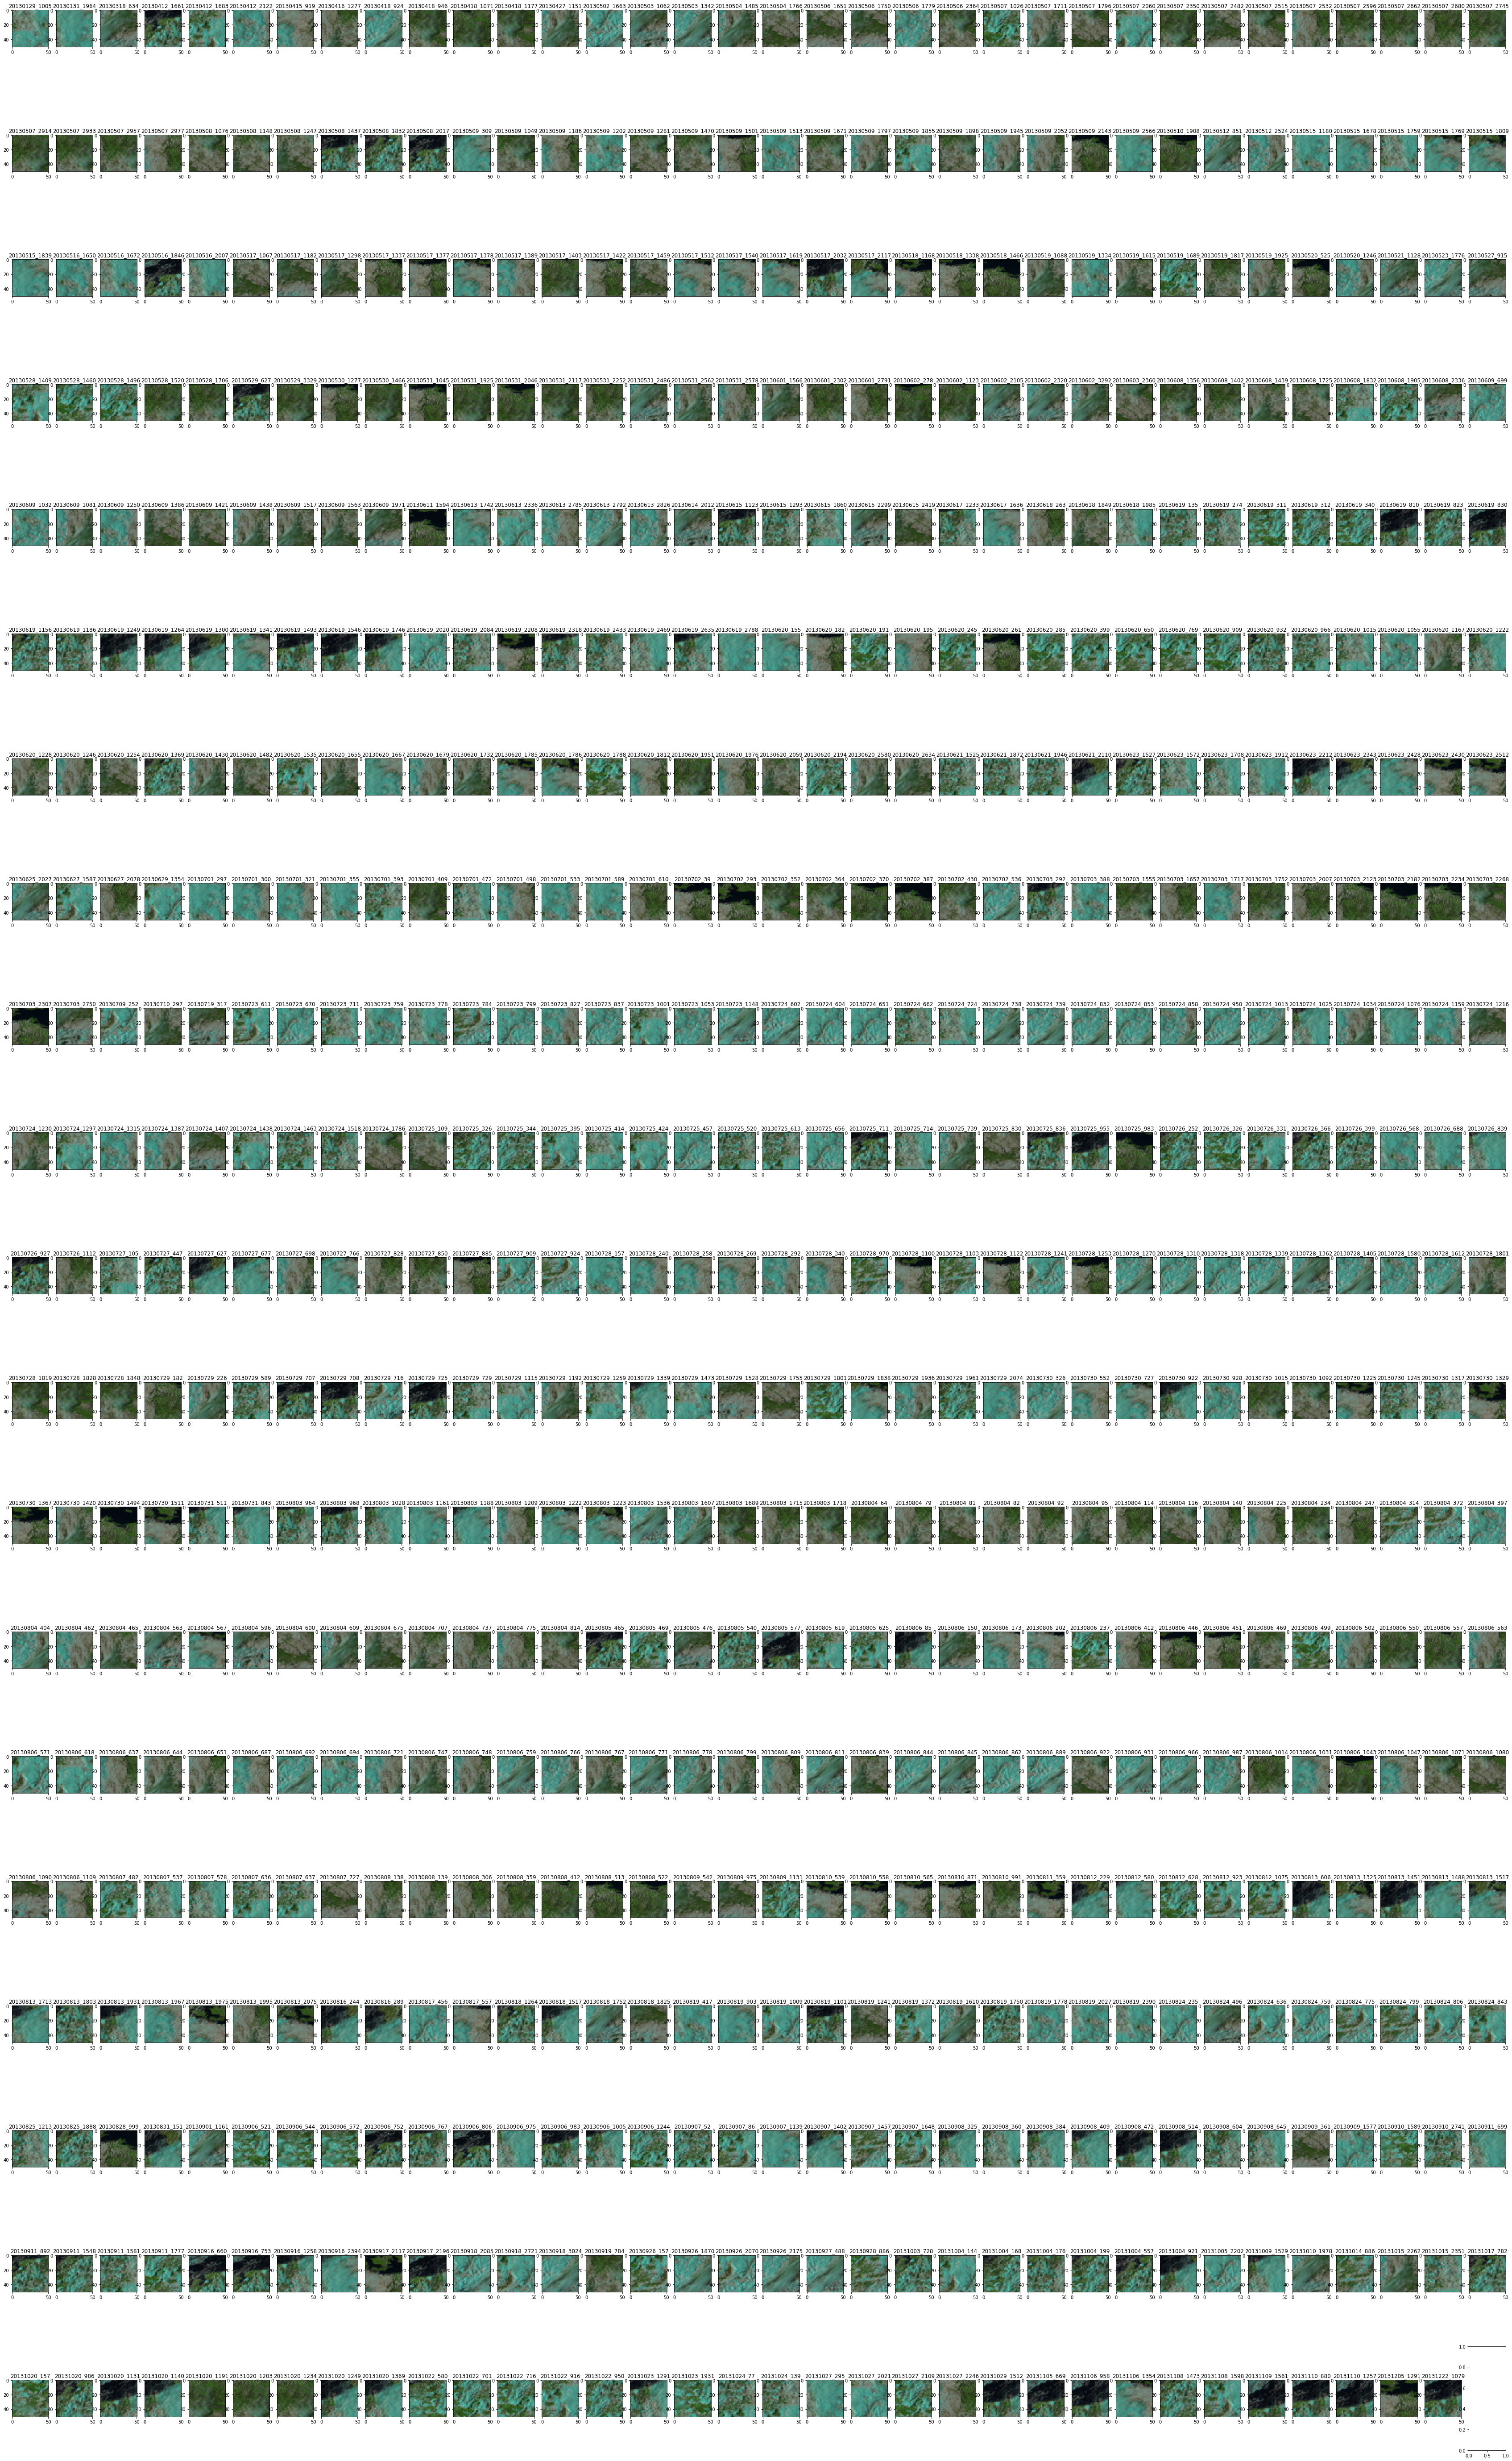

In [102]:
fig,ax = plt.subplots(20,34,figsize=(60,102))
axs = ax.ravel()

for i,k in enumerate(list(nc_cutouts.keys())):
    axs[i].imshow(nc_cutouts[k])
    axs[i].set_title(k)
    
plt.savefig("{}/proj/2019-01_trackingstudie/pics/nc_t-ci_haci_2013.png".format(local_home_path))